Connected to base (Python 3.12.7)

In [ ]:
# phd-ee homework 3 - python script for df analysis
# kelly lifchez
# due 01/27/2025

# import libraries 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sc
import scipy.optimize as opt

# Set working directories and seed

inputpath = r'/Users/kellylifchez/GaTech Dropbox/Kelly Lifchez/phdee-KL/homework3/data/raw'
outputpath = r'/Users/kellylifchez/GaTech Dropbox/Kelly Lifchez/phdee-KL/homework3/output'

#setting same seed as homeworks 1 & 2 for consistency 
np.random.seed(6578103)

# Load data - read in the df.csv file
df = pd.read_csv(os.path.join(inputpath, 'kwh.csv'))

### Question 1.e. - OLS equation estimation

# set up arrays for regression
Y = df['electricity'].to_numpy() #define dependent variable array 
n_obs, = Y.shape # get number of observations/rows
constant = np.ones((n_obs,1)) # create array/column of as many ones as there are rows/observations in Y - these will be intercept vector in regression

X = df.drop('electricity',axis = 1).to_numpy() #get rid of Y from dataframe
X = np.concatenate([constant,X],axis = 1) # add column of ones to dataframe

# generate log of Y (electricity) and z (square footage, temp)

log_Y = np.log(Y)
log_Y_rows, = np.shape(log_Y)

# use existing X array, turn columns 2(sqft) and 4(temp) into log-transformed vars 
log_X = np.copy(X)
log_X[:,1] = np.log(log_X[:,1])
log_X[:,3] = np.log(log_X[:,3])

# generate vector of OLS regression coefficients, beta = (X'X)^-1(X'Y)
beta_ols = np.matmul(np.linalg.inv((np.matmul(log_X.T, log_X))), np.matmul(log_X.T, log_Y))

## Calculate average marginal effects (ame)

me = np.zeros((log_Y_rows,4)) # set up array/matrix for marginal effects
me[:,1] = beta_ols[1]*Y*(X[:,1]**(-1)) # calculate marginal effects (me) for sq ft by multiplying sqft coefficient by Y and sqft^(-1)
me[:,3] = beta_ols[3]*Y*(X[:,3]**(-1)) # calculate me for temp by multiplying temp coefficient by Y and temp^(-1)
delta = np.exp(beta_ols[2]) # exponentiate ln(delta) to get actual value of delta 
me[:,2] = ((delta-1)*Y)*((delta**X[:,2])**(-1)) # calculate me for retrofit by multiplying (delta - 1) by Y and delta^(-1)^D
ame = np.mean(me,axis = 0) #calculate mean of marginal effect across rows of each column

## Bootstrap confidence intervals

# Set boostrap replications
reps = 1000

# set up lists for outputs
beta_ols_list = np.zeros((reps,4)) # Contains one row for each replication
ame_list = np.zeros((reps,4))

# make index of the data sample for bootstrapping (replication index)
rep_dex = np.random.choice(log_Y_rows,(log_Y_rows,reps))

## Sample with replacement to the size of the sample
for r in range(reps):
    # Sample data & clear out each run
    log_Y_b = np.zeros((log_Y_rows,1)) # array for bootstrapped log_Y
    log_X_b = np.zeros((log_Y_rows,4)) # array for bootstrapped log_X
    Y_b = np.zeros((log_Y_rows,1)) # array for bootstrapped Y
    X_b = np.zeros((log_Y_rows,4)) # array for bootstrapped X
    for n in range(log_Y_rows):
        log_Y_b[n] = log_Y[rep_dex[n,r]] # get log_Y values for each row in the replication index
        log_X_b[n,:] = log_X[rep_dex[n,r],:]
        Y_b[n] = log_Y[rep_dex[n,r]]
        X_b[n,:] = X[rep_dex[n,r],:] 
        
    log_Y_b = np.reshape(log_Y_b,-1) # change to one-dimensional array
    Y_b = np.reshape(Y_b,-1)
    
    # estimate beta ols
    beta_ols_list[r,:] = np.matmul(np.linalg.inv((np.matmul(log_X_b.T, log_X_b))), np.matmul(log_X_b.T, log_Y_b)).T # implement [ \beta = (X^T X)^{-1} X^T Y ] for each replication
    
    # Get average marginal effect as before
    ame_b = np.zeros((log_Y_rows,4))
    ame_b[:,1] = beta_ols_list[r,1]*Y_b*(X_b[:,1]**(-1)) 
    ame_b[:,3] = beta_ols_list[r,3]*Y_b*(X_b[:,3]**(-1)) 
    delta_b = np.exp(beta_ols_list[r,2]) 
    ame_b[:,2] = ((delta_b-1)*Y_b)*((delta_b**X_b[:,2])**(-1))
    ame_list[r,:] = np.mean(ame_b,axis = 0)
    
# Extract 2.5th and 97.5th percentile
lb = np.percentile(beta_ols_list,2.5,axis = 0,interpolation = 'lower')
ub = np.percentile(beta_ols_list,97.5,axis = 0,interpolation = 'higher')

lb_ame = np.percentile(ame_list,2.5,axis = 0,interpolation = 'lower')
ub_ame = np.percentile(ame_list,97.5,axis = 0,interpolation = 'higher')

## Build output table
# Reorder output (I probably should figure out a way to do this all at once)
order = np.array([2,1,3,0])
lb = lb[order]
ub = ub[order]
beta_ols = beta_ols[order]
lb_ame = lb_ame[order]
ub_ame = ub_ame[order]
ame = ame[order] 

# Row and column names
rownames = pd.concat([pd.Series(['Retrofit', 'Log(Sqft)', 'Log(Temp)', 'Constant', 'Observations']),pd.Series([' ',' ',' ',' ',])],axis = 1).stack()
colnames = pd.Series(['Coefficients','Marginal effects (dy/dx)'])

# Format confidence intervals
lb = pd.Series(np.round(lb,2)) # Rounds to two decimal places and puts into a Series
ub = pd.Series(np.round(ub,2))
lb_ame = pd.Series(np.round(lb_ame,2)).round(2)
ub_ame = pd.Series(np.round(ub_ame,2)).round(2)

# ci = '(' + lb.map(str) + ', ' + ub.map(str) + ')'
# ci_ame = '(' + lb_ame.map(str) + ', ' + ub_ame.map(str) + ')'
# ci_ame.iloc[3] = ' ' 

ci = pd.Series([f'({l}, {u})' for l, u in zip(lb, ub)])
ci_ame = pd.Series([f'({l}, {u})' for l, u in zip(lb_ame, ub_ame)])
ci_ame.at[3] = ' '

# Format estimates and append observations
beta_ols = pd.Series(np.append(np.round(beta_ols,2),log_Y_rows)).round(2)
ame = pd.Series(np.append(np.round(ame,2),log_Y_rows)).round(2)
ame.at[3] = ' ' 

# Stack estimates over confidence intervals
col0 = pd.concat([beta_ols,ci],axis = 1).stack()
col1 = pd.concat([ame,ci_ame],axis = 1).stack()

## Output
outputtable = pd.concat([col0,col1],axis = 1)
outputtable.index = rownames
outputtable.columns = colnames

print(outputtable)

                Coefficients Marginal effects (dy/dx)
Retrofit                -0.1                  -113.98
              (-0.11, -0.09)           (-0.79, -0.61)
Log(Sqft)               0.89                     0.63
                (0.88, 0.91)               (0.0, 0.0)
Log(Temp)               0.28                      4.0
                (0.04, 0.53)              (0.0, 0.05)
Constant               -0.77                         
               (-1.88, 0.33)                         
Observations          1000.0                   1000.0


<ipython-input-1-2199cd7623db>:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value ' ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ame.at[3] = ' '


In [ ]:
outputtable.to_latex(os.path.join(outputpath, 'outputtable.tex'))

<ipython-input-3-5aeab4787f03>:135: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value ' ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ame.at[3] = ' '


                Coefficients Marginal effects (dy/dx)
Retrofit                -0.1                  -113.98
              (-0.11, -0.09)           (-0.79, -0.61)
Log(Sqft)               0.89                     0.63
                (0.88, 0.91)               (0.0, 0.0)
Log(Temp)               0.28                      4.0
                (0.04, 0.53)              (0.0, 0.05)
Constant               -0.77                         
               (-1.88, 0.33)                         
Observations          1000.0                   1000.0


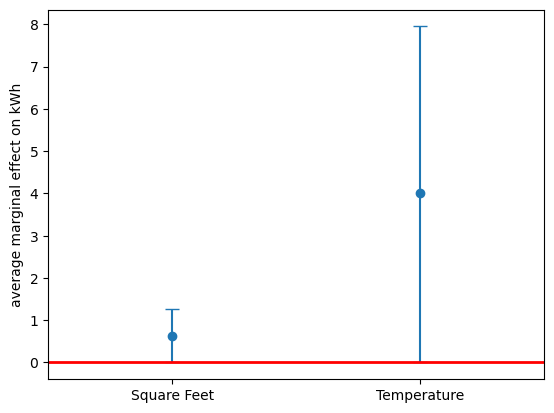

In [ ]:
# phd-ee homework 3 - python script for df analysis
# kelly lifchez
# due 01/27/2025

# import libraries 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sc
import scipy.optimize as opt

# Set working directories and seed

inputpath = r'/Users/kellylifchez/GaTech Dropbox/Kelly Lifchez/phdee-KL/homework3/data/raw'
outputpath = r'/Users/kellylifchez/GaTech Dropbox/Kelly Lifchez/phdee-KL/homework3/output'

#setting same seed as homeworks 1 & 2 for consistency 
np.random.seed(6578103)

# Load data - read in the df.csv file
df = pd.read_csv(os.path.join(inputpath, 'kwh.csv'))

### Question 1.e. - OLS equation estimation

# set up arrays for regression
Y = df['electricity'].to_numpy() #define dependent variable array 
n_obs, = Y.shape # get number of observations/rows
constant = np.ones((n_obs,1)) # create array/column of as many ones as there are rows/observations in Y - these will be intercept vector in regression

X = df.drop('electricity',axis = 1).to_numpy() #get rid of Y from dataframe
X = np.concatenate([constant,X],axis = 1) # add column of ones to dataframe

# generate log of Y (electricity) and z (square footage, temp)

log_Y = np.log(Y)
log_Y_rows, = np.shape(log_Y)

# use existing X array, turn columns 2(sqft) and 4(temp) into log-transformed vars 
log_X = np.copy(X)
log_X[:,1] = np.log(log_X[:,1])
log_X[:,3] = np.log(log_X[:,3])

# generate vector of OLS regression coefficients, beta = (X'X)^-1(X'Y)
beta_ols = np.matmul(np.linalg.inv((np.matmul(log_X.T, log_X))), np.matmul(log_X.T, log_Y))

## Calculate average marginal effects (ame)

me = np.zeros((log_Y_rows,4)) # set up array/matrix for marginal effects
me[:,1] = beta_ols[1]*Y*(X[:,1]**(-1)) # calculate marginal effects (me) for sq ft by multiplying sqft coefficient by Y and sqft^(-1)
me[:,3] = beta_ols[3]*Y*(X[:,3]**(-1)) # calculate me for temp by multiplying temp coefficient by Y and temp^(-1)
delta = np.exp(beta_ols[2]) # exponentiate ln(delta) to get actual value of delta 
me[:,2] = ((delta-1)*Y)*((delta**X[:,2])**(-1)) # calculate me for retrofit by multiplying (delta - 1) by Y and delta^(-1)^D
ame = np.mean(me,axis = 0) #calculate mean of marginal effect across rows of each column

## Bootstrap confidence intervals

# Set boostrap replications
reps = 1000

# set up lists for outputs
beta_ols_list = np.zeros((reps,4)) # Contains one row for each replication
ame_list = np.zeros((reps,4))

# make index of the data sample for bootstrapping (replication index)
rep_dex = np.random.choice(log_Y_rows,(log_Y_rows,reps))

## Sample with replacement to the size of the sample
for r in range(reps):
    # Sample data & clear out each run
    log_Y_b = np.zeros((log_Y_rows,1)) # array for bootstrapped log_Y
    log_X_b = np.zeros((log_Y_rows,4)) # array for bootstrapped log_X
    Y_b = np.zeros((log_Y_rows,1)) # array for bootstrapped Y
    X_b = np.zeros((log_Y_rows,4)) # array for bootstrapped X
    for n in range(log_Y_rows):
        log_Y_b[n] = log_Y[rep_dex[n,r]] # get log_Y values for each row in the replication index
        log_X_b[n,:] = log_X[rep_dex[n,r],:]
        Y_b[n] = log_Y[rep_dex[n,r]]
        X_b[n,:] = X[rep_dex[n,r],:] 
        
    log_Y_b = np.reshape(log_Y_b,-1) # change to one-dimensional array
    Y_b = np.reshape(Y_b,-1)
    
    # estimate beta ols
    beta_ols_list[r,:] = np.matmul(np.linalg.inv((np.matmul(log_X_b.T, log_X_b))), np.matmul(log_X_b.T, log_Y_b)).T # implement [ \beta = (X^T X)^{-1} X^T Y ] for each replication
    
    # Get average marginal effect as before
    ame_b = np.zeros((log_Y_rows,4))
    ame_b[:,1] = beta_ols_list[r,1]*Y_b*(X_b[:,1]**(-1)) 
    ame_b[:,3] = beta_ols_list[r,3]*Y_b*(X_b[:,3]**(-1)) 
    delta_b = np.exp(beta_ols_list[r,2]) 
    ame_b[:,2] = ((delta_b-1)*Y_b)*((delta_b**X_b[:,2])**(-1))
    ame_list[r,:] = np.mean(ame_b,axis = 0)
    
# Extract 2.5th and 97.5th percentile
lb = np.percentile(beta_ols_list,2.5,axis = 0,interpolation = 'lower')
ub = np.percentile(beta_ols_list,97.5,axis = 0,interpolation = 'higher')

lb_ame = np.percentile(ame_list,2.5,axis = 0,interpolation = 'lower')
ub_ame = np.percentile(ame_list,97.5,axis = 0,interpolation = 'higher')

## Build output table
# Reorder output (I probably should figure out a way to do this all at once)
order = np.array([2,1,3,0])
lb = lb[order]
ub = ub[order]
beta_ols = beta_ols[order]
lb_ame = lb_ame[order]
ub_ame = ub_ame[order]
ame = ame[order] 

# Row and column names
rownames = pd.concat([pd.Series(['Retrofit', 'Log(Sqft)', 'Log(Temp)', 'Constant', 'Observations']),pd.Series([' ',' ',' ',' ',])],axis = 1).stack()
colnames = pd.Series(['Coefficients','Marginal effects (dy/dx)'])

# Format confidence intervals
lb = pd.Series(np.round(lb,2)) # Rounds to two decimal places and puts into a Series
ub = pd.Series(np.round(ub,2))
lb_ame = pd.Series(np.round(lb_ame,2)).round(2)
ub_ame = pd.Series(np.round(ub_ame,2)).round(2)

# ci = '(' + lb.map(str) + ', ' + ub.map(str) + ')'
# ci_ame = '(' + lb_ame.map(str) + ', ' + ub_ame.map(str) + ')'
# ci_ame.iloc[3] = ' ' 

ci = pd.Series([f'({l}, {u})' for l, u in zip(lb, ub)])
ci_ame = pd.Series([f'({l}, {u})' for l, u in zip(lb_ame, ub_ame)])
ci_ame.at[3] = ' '

# Format estimates and append observations
beta_ols = pd.Series(np.append(np.round(beta_ols,2),log_Y_rows)).round(2)
ame = pd.Series(np.append(np.round(ame,2),log_Y_rows)).round(2)
ame.at[3] = ' ' 

# Stack estimates over confidence intervals
col0 = pd.concat([beta_ols,ci],axis = 1).stack()
col1 = pd.concat([ame,ci_ame],axis = 1).stack()

## Output
outputtable = pd.concat([col0,col1],axis = 1)
outputtable.index = rownames
outputtable.columns = colnames

print(outputtable)


outputtable.to_latex(os.path.join(outputpath, 'outputtable.tex'))

### Question 1.f. - Graph AME with confidence intervals
#%%
## Build plot
low = np.abs(np.array(lb_ame[1:3] - ame[1:3]))
high = np.abs(np.array(ub_ame[1:3] - ame[1:3]))

plt.errorbar(x=np.arange(2), y=ame[1:3], yerr=[low, high], fmt='o', capsize=5)
plt.ylabel('average marginal effect on kWh')
plt.xticks(np.arange(2), ['Square Feet', 'Temperature'])
plt.xlim((-0.5,1.5)) # scaling
plt.axhline(linewidth=2, color='r')
plt.savefig(os.path.join(outputpath, 'ame_plot.png'))
plt.show()